In [1]:
### 週販レポート2025年版

# 標準ライブラリ
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi

hard_sales_df = hs.load_hard_sales()

def show_title(df: pd.DataFrame) -> None:
    last_updated_str = hs.current_report_date(df).strftime("%Y-%m-%d")
    display(Markdown(f"# ハード週販状況 ({last_updated_str})"))

show_title(hard_sales_df)

# ハード週販状況 (2025-08-17)

## 直近4週間のハード売り上げ／累計推移


In [2]:
def last4weeks_report(df: pd.DataFrame) -> pd.DataFrame:
    last4weeks_df = hs.extract_latest(df, weeks=4)[['report_date', 'full_name', 'units', 'sum_units']]
    
    last4weeks_df.set_index(['report_date', 'full_name'], inplace=True)
    last4weeks_df.sort_values(by=['report_date', 'units', 'full_name'], ascending=[True, False, True], inplace=True)

    # カラム名を日本語にする
    last4weeks_df.columns = ['販売数', '累計']
    # indexを日本語にする
    last4weeks_df.index.names = ['報告日', 'ハード']
    last4weeks_df.index = last4weeks_df.index.set_levels(
        last4weeks_df.index.levels[0].strftime('%Y-%m-%d'), level=0
    )
    # スタイルを適用して表示
    last4weeks_df.style.format({'販売数': '{:,}', '累計': '{:,}'})
    return last4weeks_df

last4weeks_report(hard_sales_df)

販売数        累計
報告日        ハード                              
2025-07-27 Nintendo Switch2  92013   1614390
           Nintendo Switch   14643  35850981
           PlayStation5       6920   6939238
           Xbox Series X|S     271    681795
           PlayStation4         18   9490688
2025-08-03 Nintendo Switch2  62733   1677123
           Nintendo Switch   18637  35869618
           PlayStation5       7141   6946379
           Xbox Series X|S     271    682066
           PlayStation4         19   9490707
2025-08-10 Nintendo Switch2  89820   1766943
           Nintendo Switch   18673  35888291
           PlayStation5       8565   6954944
           Xbox Series X|S     326    682392
           PlayStation4         16   9490723
2025-08-17 Nintendo Switch2  89821   1856764
           Nintendo Switch   18673  35906964
           PlayStation5       8566   6963510
           Xbox Series X|S     326    682718
           PlayStation4         16   9490739

## 直近6ヶ月の販売推移

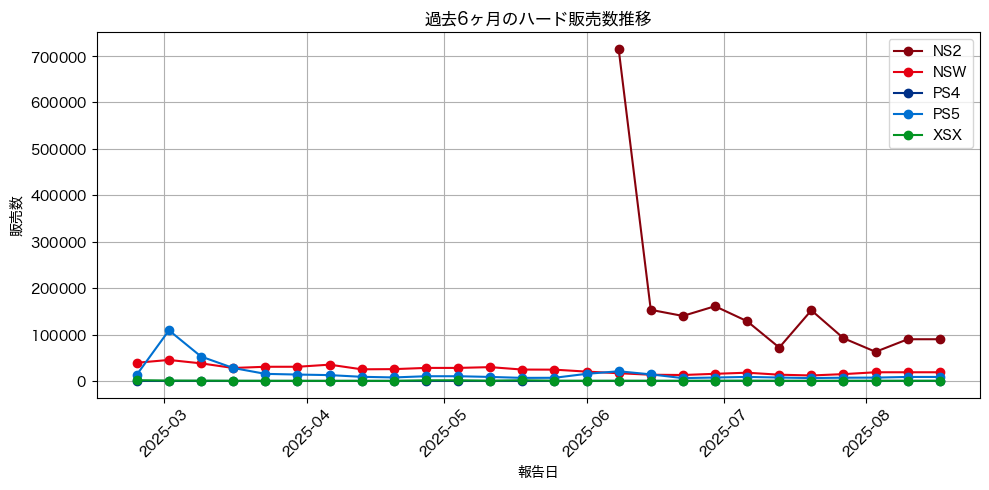

In [3]:
# 半年間の販売数折れ線グラフ
def plot_recent_sales(df:pd.DataFrame, months:int = 6, exclude:list[str] = []) -> None:
    recent_df = hs.extract_latest(df, weeks=months*31//7)
    pivot_df = hs.pivot_sales(recent_df)   
    
    # 日本語ラベルのためのフォント設定
    plt.rcParams['font.family'] = 'Hiragino Sans'
    plt.rcParams['axes.unicode_minus'] = False
    fig, ax = plt.subplots(figsize=ph.get_figsize())
    for column in pivot_df.columns:
        if column in exclude:
            continue
        col = hi.get_hard_colors([column])[0]
        ax.plot(pivot_df.index, pivot_df[column], marker='o', label=str(column), color=col)

    ax.set_title(f'過去{months}ヶ月のハード販売数推移')
    ax.set_xlabel('報告日')
    ax.set_ylabel('販売数')
    ax.legend()
    ax.grid(True)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.tick_params(axis='x', rotation=45)
    fig.tight_layout()
    plt.show()


plot_recent_sales(hard_sales_df, months=6)




Switch2のロンチ週が突出しているため他機種の状況がわかりません。Switch2を除いた販売推移はこちら。

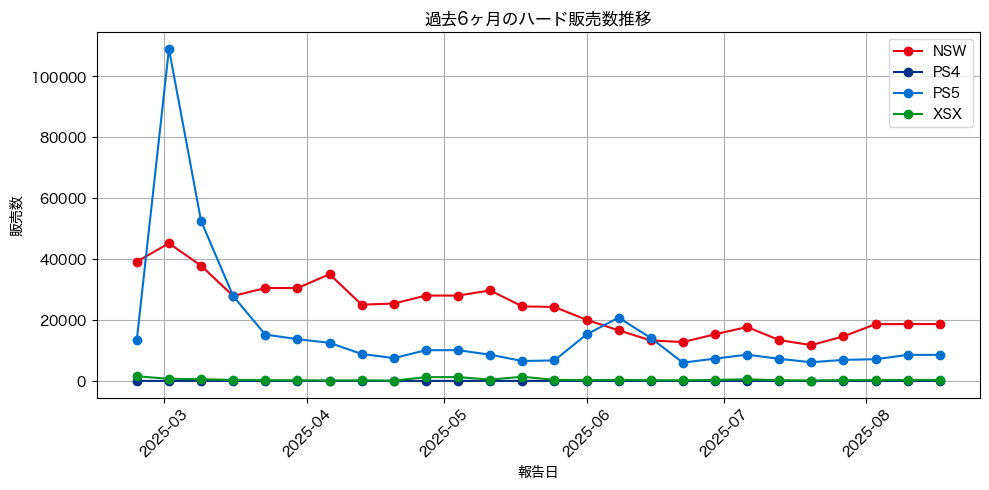

In [4]:
plot_recent_sales(hard_sales_df, months=6, exclude=['NS2'])

## 累計状況

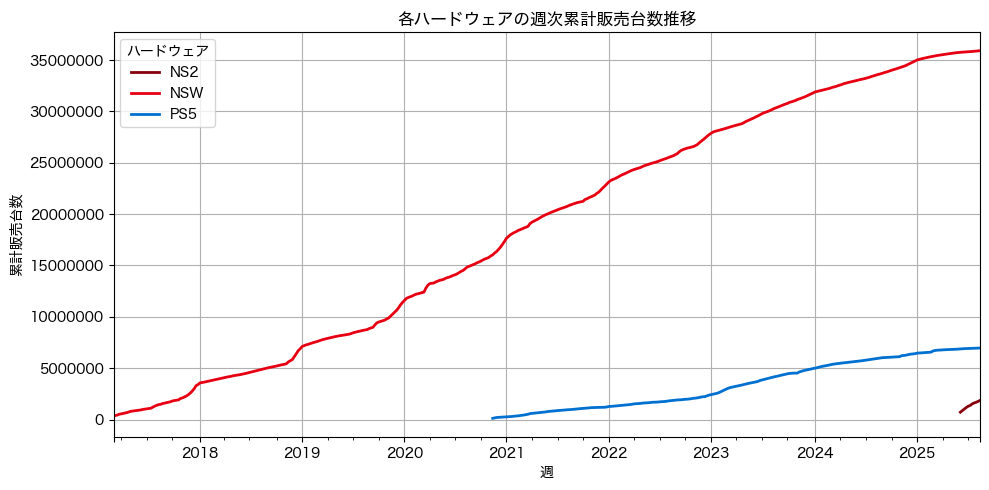

In [5]:
fig = ph.plot_cumulative_sales(hard_sales_df, hw=['NS2', 'PS5', 'NSW'])

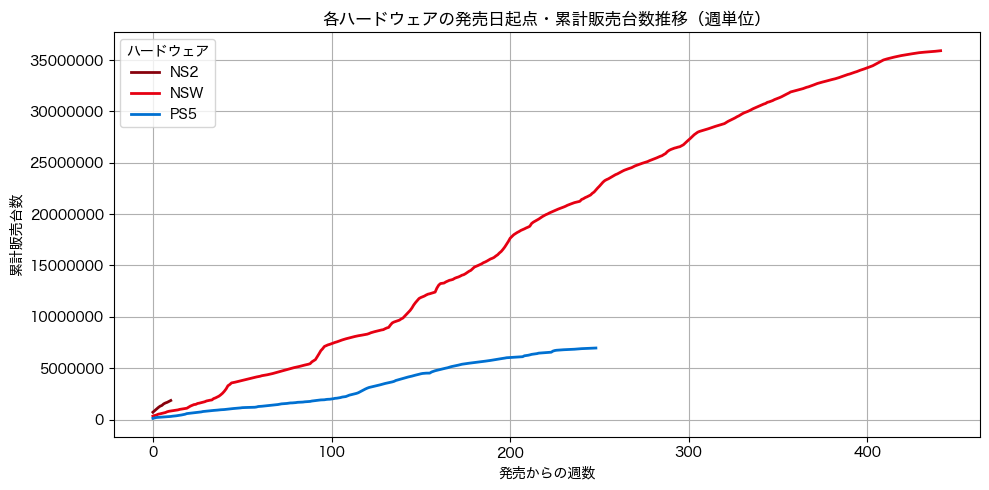

In [6]:
fig2 = ph.plot_cumulative_sales_by_delta(hard_sales_df, hw=['NS2', 'PS5', 'NSW'])

## ハード販売シェア

2025年のシェアは1月から現時点までの状況です。

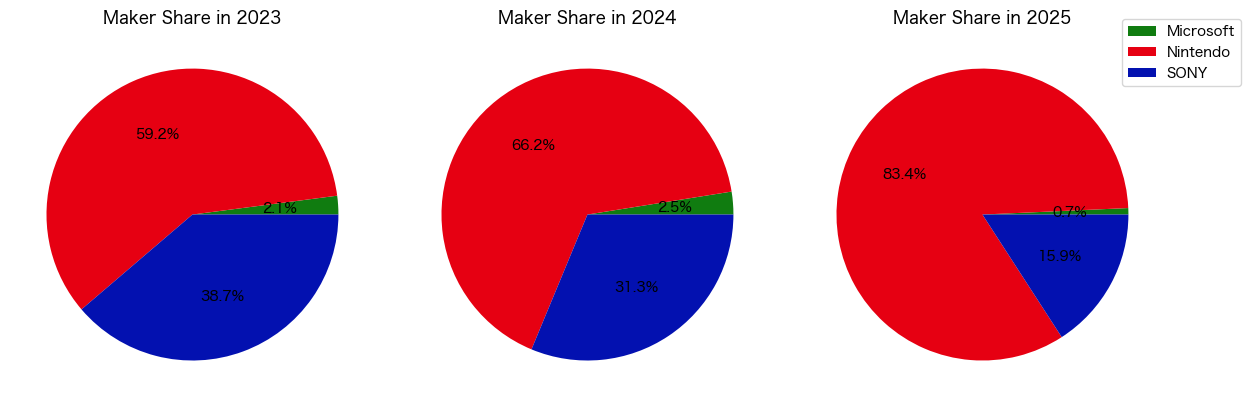

In [7]:
def plot_maker_share_pie(hard_sales_df: pd.DataFrame, start_year: int = 2023) -> None:
    """
    年ごとのメーカーシェアを円グラフで可視化する

    Parameters
    ----------
    hard_sales_df : pd.DataFrame
        load_hard_sales()で取得した週次販売データ
    start_year : int
        表示する最初の年（デフォルト: 2023）
    """
    maker_sales = hs.pivot_maker(hard_sales_df).resample('Y').sum().loc[f'{start_year}':]
    # 全ての行の値が0の列を削除
    maker_sales = maker_sales.loc[:, (maker_sales != 0).any(axis=0)]

    n = len(maker_sales)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    legend_labels = None
    legend_handles = None
    for i, (ax, (idx, s)) in enumerate(zip(axes, maker_sales.iterrows())):
        s_data = s[s > 0]
        colors = hi.get_maker_colors(s_data.index.to_list())
        wedges, texts, autotexts = ax.pie(s_data, labels=None, autopct='%1.1f%%', colors=colors)
        ax.set_title(f'Maker Share in {s.name.year}')
        if i == 0:
            legend_labels = s_data.index.to_list()
            legend_handles = wedges
    if legend_handles and legend_labels:
        fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# 使い方例
plot_maker_share_pie(hard_sales_df, start_year=2023)

## Switch2販売状況

### 歴代初動が高い機種との比較

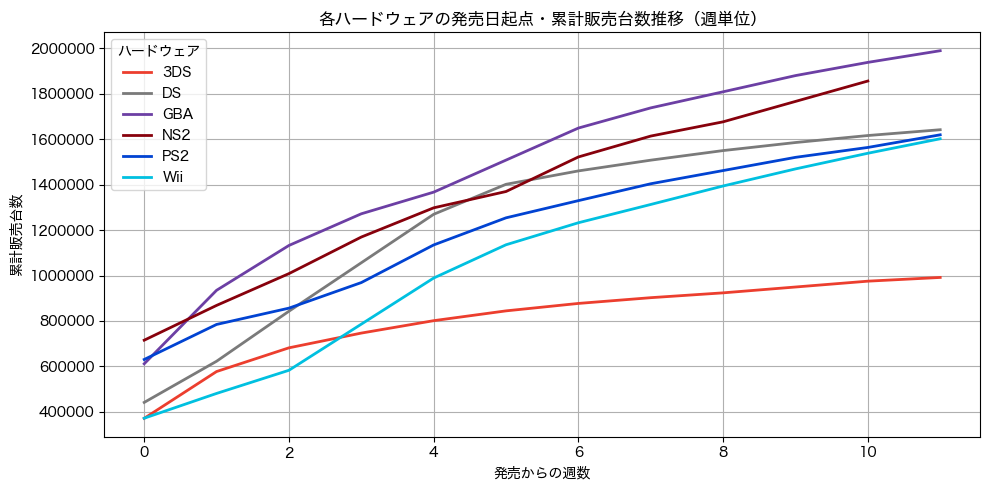

In [8]:
fig3 = ph.plot_cumulative_sales_by_delta(hard_sales_df, 
                                         hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                         limit=12, mode="week")

### PS5/Switch2累積台数差

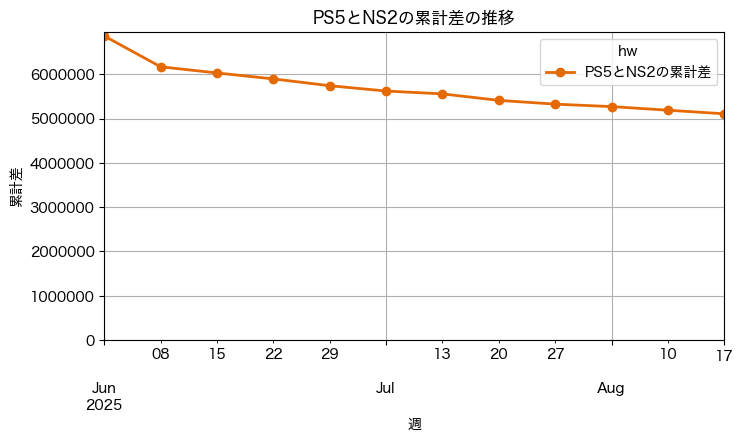

In [ ]:
def cumsum_diff(df:pd.DataFrame, base_hw:str, cmp_hw:str) -> pd.DataFrame:
    cumsum_df = hs.pivot_cumulative_sales(df, hw=[base_hw, cmp_hw])
    # column:cmp_hwの値がNA以外になった最初の行の直前のindexを得る
    first_valid_index = cumsum_df[cmp_hw].first_valid_index()
    if first_valid_index is not None:
        idx_list = list(cumsum_df.index)
        pos = idx_list.index(first_valid_index)
        # 直前の行が存在する場合はそのindexから
        start_pos = max(pos - 1, 0)
        start_index = idx_list[start_pos]
        cumsum_df = cumsum_df[cumsum_df.index >= start_index]

    cumsum_df = cumsum_df.fillna(0)
    cumsum_df["diff"] = cumsum_df[base_hw] - cumsum_df[cmp_hw]
    cumsum_df = cumsum_df[cumsum_df["diff"] >= -20000]
    return cumsum_df[["diff"]].rename(columns={"diff": f"{base_hw}と{cmp_hw}の累計差"})

def plot_cumsum_diff(df:pd.DataFrame, base_hw:str, cmp_hw:str, marker:bool=True) -> None:
    cumsum_diff_df = cumsum_diff(df, base_hw, cmp_hw)

    fig, ax = plt.subplots(figsize=ph.get_figsize()))
    plt.rcParams['font.family'] = 'Hiragino Sans'
    plt.rcParams['axes.unicode_minus'] = False
    if marker:
        marker_str = 'o'
    else:
        marker_str = ''
    cumsum_diff_df.plot(ax=ax, kind='line', marker=marker_str, 
                        linewidth=2, color="#E56A06")
    ax.set_title(f"{base_hw}と{cmp_hw}の累計差の推移")
    ax.set_xlabel("週")
    ax.set_ylabel("累計差")
    # 縦軸の表示を指数表示から整数表示に変更
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_ylim(bottom=0)
    ax.grid(True)

plot_cumsum_diff(hard_sales_df, "PS5", "NS2")


#### 参考:PS4とSwitchとの累計差の推移

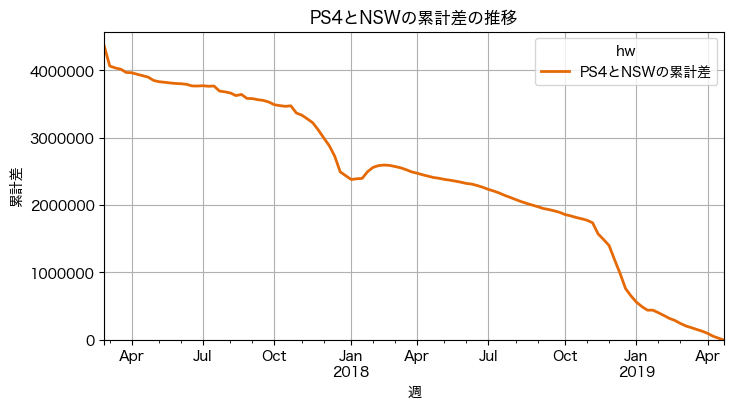

In [10]:

ps4_nsw = plot_cumsum_diff(hard_sales_df, "PS4", "NSW", marker=False)


* ハードウェアの販売データはファミ通の調査結果を元にしています。
* 一部のデータについては処理の都合上、1週間毎の値にアレンジしています。